## Introduction

* **Challenge**: Quantinuum | Womanium
* **Team**: Quriosity
* Effort per person (scale 1-10)
    - Gehad:      10 
    - Tessa:      10
    - Tariq :      1
    - Etendra:     1
    - Adhish:      3
    - Sylvester:   3

-----
# Installation and importing packages
 

In [ ]:
!pip install wordcloud

In [1]:
import os
import sys
import numpy
import random
import socket
import numpy as np
import pandas as pd
from math import ceil
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from tqdm.autonotebook import tqdm
from __future__ import annotations
from sklearn.model_selection import train_test_split
from collections.abc import Callable, Mapping
from typing import Any, Optional, Union
from abc import ABC, abstractmethod
from collections.abc import Callable, Mapping
from typing import TYPE_CHECKING
if TYPE_CHECKING:
    from torch.utils.tensorboard import SummaryWriter
from sympy import default_sort_key, lambdify

from wordcloud import WordCloud, STOPWORDS

In [2]:
from discopy.tensor import Diagram
from discopy import grammar, Tensor
from lambeq.training.model import Model
from lambeq.training.trainer import Trainer
from lambeq.training.dataset import Dataset
from lambeq.core.globals import VerbosityLevel
from lambeq.training.checkpoint import Checkpoint
from lambeq.training.optimizer import Optimizer
from lambeq.training.quantum_model import QuantumModel
from lambeq import BobcatParser, AtomicType, IQPAnsatz, remove_cups, QuantumTrainer, SPSAOptimizer, NumpyModel

In [3]:
import nltk
# nltk.download('punkt')
nltk.download('wordnet')
import nltk.corpus
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import blankline_tokenize, word_tokenize, sent_tokenize 
from nltk.util import bigrams, trigrams, ngrams

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Define functions
 

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            sentences.append(line[0:(len(line)-4)].strip())
            t = int(line[(len(line)-2)])
            # labels.append([t, 1-t]) // G: Wasn't compiling the model
            labels.append(t)
    return labels, sentences

In [5]:
# Splitting the data array for left sentences and array for right sentences data
def split_sentences(data):
    sentences_1, sentences_2 = [], []
    for sentence in data:
        sentences_1.append(sentence.split(', ')[0])
        sentences_2.append(sentence.split(', ')[1])
    return sentences_1, sentences_2

In [6]:
# In this scenario not mainly relevant, still included a piece of classical preprocessing. 
def delstopwrds(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))#+["JJ", "JJR", "JJS", "NN"]
    words = word_tokenize(text.lower())
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)

def lemtxt(text):
    wordlist = []
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return " ".join(wordlist)

---
# Task 2: Get an overview of the dataset

In [7]:
# Import data Quantinuum
data_labels, data_sentences = read_data('MC1.TXT')

In [8]:
# Have a look 
df0 = pd.DataFrame(data_labels)
df1 = pd.DataFrame(data_sentences)
df = pd.DataFrame()
df['sentences'] = df1.copy()
df['similar'] = df0.copy()

In [9]:
df

,sentences,similar
0,"cook creates complicated dish, experienced che...",1
1,"skilful programmer creates code, devoted hacke...",1
2,"skilful cook creates meal, devoted hacker crea...",0
3,"hacker writes code, skilful hacker creates code",1
4,"devoted hacker writes code, hacker writes comp...",1
...,...,...
95,"skilful programmer writes advanced code, skilf...",0
96,"programmer creates code, chef creates dish",0
97,"hacker creates code, chef prepares dish",0
98,"skilful programmer creates complicated code, p...",1


In [10]:
# draft test frequence of words
def frequency(data):
    fdist = FreqDist()
    for row in data:
        for word in row.split(" "):
            fdist[word.lower()]+=1
    return fdist

In [11]:
data_sentences[0]

'cook creates complicated dish, experienced chef prepares complicated dish'

In [12]:
# Split the data for training and test purposes
train_sentences, val_sentences, train_labels, val_labels = train_test_split(data_sentences, data_labels, test_size=0.20, random_state=42)

In [13]:
train_sentences_l, train_sentences_r = split_sentences(train_sentences)
val_sentences_l, val_sentences_r = split_sentences(val_sentences)

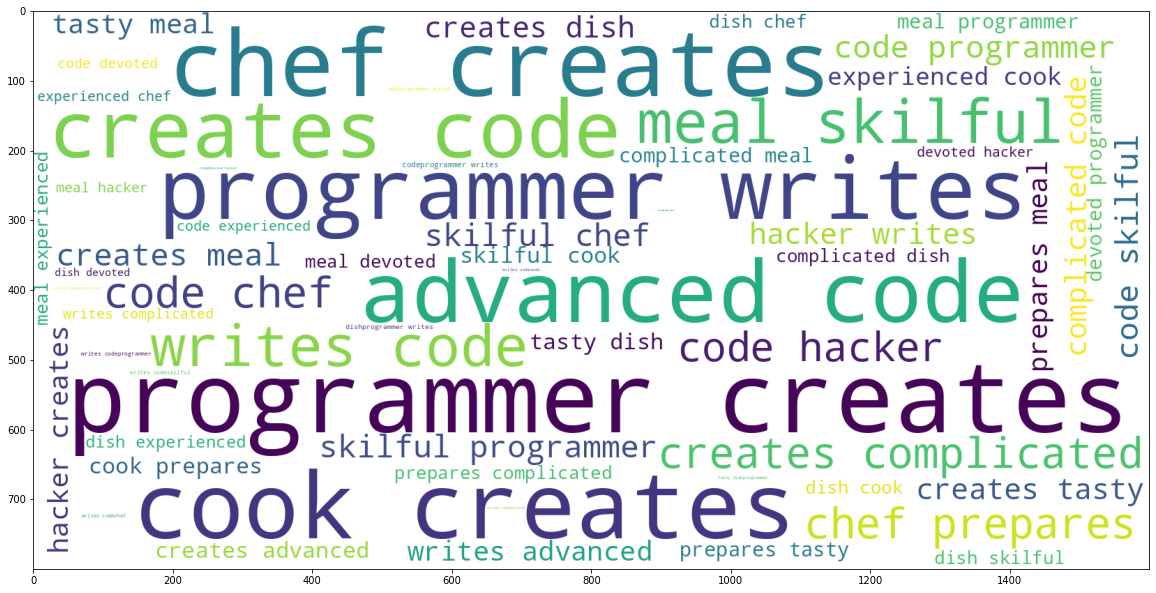

In [14]:
# Visualising the training sentences 
wordcloud = WordCloud(background_color = 'white', height = 800, width = 1600).generate((' '.join(train_sentences_l)).join(train_sentences_r))
plt.figure(figsize=(20,30))
plt.imshow(wordcloud)

---------
# Task 3: Parse sentences to diagrams


### 3A. Parsing


In [15]:
parser = BobcatParser() 

### 3B. Sentences to diagrams


In [16]:
# one time for the left sentence
raw_train_diagrams_l = parser.sentences2diagrams(train_sentences_l)#, suppress_exceptions=True)
raw_val_diagrams_l = parser.sentences2diagrams(val_sentences_l)#, suppress_exceptions=True)

# another time for the right sentence
raw_train_diagrams_r = parser.sentences2diagrams(train_sentences_r)#, suppress_exceptions=True)
raw_val_diagrams_r = parser.sentences2diagrams(val_sentences_r)#, suppress_exceptions=True)

Tagging sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/80 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/80 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/5 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/20 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/80 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/80 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/5 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/20 [00:00<?, ?it/s]

### 3C. Normal forms of diagrams


In [17]:
# one time for the left sentence
train_diagrams_l = [
    diagram.normal_form()
    for diagram in raw_train_diagrams_l if diagram is not None
]
val_diagrams_l = [
    diagram.normal_form()
    for diagram in raw_val_diagrams_l if diagram is not None
]

# another time for the right sentence
train_diagrams_r = [
    diagram.normal_form()
    for diagram in raw_train_diagrams_r if diagram is not None
]
val_diagrams_r = [
    diagram.normal_form()
    for diagram in raw_val_diagrams_r if diagram is not None
]


In [18]:
train_labels_zip = [
    label for (diagram, label)
    in zip(raw_train_diagrams_l + raw_train_diagrams_r, train_labels)
    if diagram is not None]
val_labels_zip = [
    label for (diagram, label)
    in zip(raw_val_diagrams_l + raw_val_diagrams_r, val_labels)
    if diagram is not None
]

### 3D. Having a look at the output


In [19]:
# raw_train_diagrams_l

---------

# Task 4: From diagram to circuit

### Description
* Actions
    - Try different number of qubits
    - Try differrent ansatz layers
    - Look if hyperparameter tuning can be use like in classical computing when training classified models f.e.!


The Instantaneous Quantum Polynomial(IQP) ansatz
* Layers of Hadamard gates with diagonal unitaries 
* It uses n_layers-1 adjecent CRz gates to implement each diagonal unitary.
* The input paramaters are 
    * ob_map = A mapping from discopy.rigid.Ty to the number of qubits it uses in a circuit.
    * n_layers = The number of IQP layers used by the ansatz.
    * n_single_qubit_params (by default 3) = The number of single qubit rotations used by the ansatz.
    * discard (by default False) = Discard open wires instead of post-selecting.
    * special_cases = A function that transforms an arrow map into one specifying special cases that should not be converted by thte Ansatz class. 

### 4A. Another Method for Ansatz code:
Note that we remove the cups before parameterising the diagrams. By doing so, we reduce the number of post-selections, which makes the model computationally more efficient.

In [20]:
# Define the paramaters 
# Next up: Interesting is to vary these values and see the impact on the model results
par_noun = 2
par_sen = 0
par_layer = 1
par_qubit = 3

In [21]:
# Currently we only use the IQPAnsatz, where we investigated the literature in order to understand
# the general way of working. Next up: Think of improvements etc. 

ansatz = IQPAnsatz({AtomicType.NOUN: par_noun, AtomicType.SENTENCE: par_sen },
                   n_layers=par_layer, n_single_qubit_params= par_qubit)

In [22]:
# experimenting with left and right sentences but not sure if this is the right way to do it
train_circuits_l = [ansatz(remove_cups(diagram)) for diagram in train_diagrams_l]
val_circuits_l =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams_l]

train_circuits_r = [ansatz(remove_cups(diagram)) for diagram in train_diagrams_r]
val_circuits_r =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams_r]

----
# Task 5: Define the learning objective



### 5A. Instantiate the model:

In [50]:
# We created our own model, leveraging on the NumpyModel
# source: https://cqcl.github.io/lambeq/_modules/lambeq/training/numpy_model.html#NumpyModel

class ComparisonModelSim(NumpyModel):
    # note that a NumpyModel is a QuantumModel
    def __init__(self, use_jit: bool = False, **kwargs) -> None:
        """Initialise a :py:class:`QuantumModel`."""
        super().__init__()

        self._training = False
        self._train_predictions : list[Any] = []
        self.use_jit = use_jit
        self.lambdas: dict[Diagram, Callable] = {}
    
    @classmethod
    def from_diagrams(cls,
                      diagrams_left: list[Diagram],
                      diagrams_right: list[Diagram],
                      use_jit: bool = False,
                      **kwargs) -> NumpyModel:
        
        """Build model from a list of
        :py:class:`Diagrams <discopy.tensor.Diagram>`

        Parameters
        ----------
        diagrams : list of :py:class:`~discopy.tensor.Diagram`
            The :py:class:`Circuits <discopy.quantum.circuit.Circuit>`
            to be evaluated.
        use_jit : bool, default: False
            Whether to use JAX's Just-In-Time compilation.

        Returns
        -------
        NumpyModel
            The NumPy model initialised from the diagrams.

        """

        model = cls(use_jit=use_jit, **kwargs)
        model.symbols = sorted(
            {sym for circ in diagrams_right for sym in circ.free_symbols},
            key=default_sort_key)
        return model
    
    
    def get_diagram_output(self, diagrams: list[Diagram]) -> numpy.ndarray: 
      
        """Return the exact prediction for each diagram.

        Parameters
        ----------
        diagrams : list of :py:class:`~discopy.tensor.Diagram`
            The :py:class:`Circuits <discopy.quantum.circuit.Circuit>`
            to be evaluated.

        Raises
        ------
        ValueError
            If `model.weights` or `model.symbols` are not initialised.

        Returns
        -------
        np.ndarray
            Resulting array.

        """
        if len(self.weights) == 0 or not self.symbols:
            raise ValueError('Weights and/or symbols not initialised. '
                             'Instantiate through '
                             '`NumpyModel.from_diagrams()` first, '
                             'then call `initialise_weights()`, or load '
                             'from pre-trained checkpoint.')
 
        if self.use_jit: 
            lambdified_diagrams = [self._get_lambda(d) for d in diagrams]
            return numpy.array([diag_f(*self.weights) for diag_f in lambdified_diagrams]) 
 
        diagrams = self._fast_subs(diagrams, self.weights)
        with Tensor.backend('numpy'):
            results = []
            for d in diagrams:
                result = tn.contractors.auto(*d.to_tn()).tensor  

                # square amplitudes to get probabilties for pure circuits
                if not d.is_mixed:
                    result = numpy.abs(result) ** 2
                results.append(self._normalise_vector(result))
            return numpy.array(results) ## we will go back to step 8


    def _clear_predictions(self) -> None:
        """Clear the logged predictions of the model."""
        self._train_predictions = []

    def get_diagram_output_for_similarity(self, diagrams: list[Diagram]) -> numpy.ndarray: 
        """ Returns tensornetworks"""
        if len(self.weights) == 0 or not self.symbols:
            raise ValueError('Weights and/or symbols not initialised. '
                             'Instantiate through '
                             '`NumpyModel.from_diagrams()` first, '
                             'then call `initialise_weights()`, or load '
                             'from pre-trained checkpoint.')
 
        if self.use_jit: 
            lambdified_diagrams = [self._get_lambda(d) for d in diagrams]    
            return numpy.array([diag_f(*self.weights) for diag_f in lambdified_diagrams])
            
        diagrams = self._fast_subs(diagrams, self.weights)
        with Tensor.backend('numpy'):
            tensor_diagrams = [] 
            for d in diagrams:
                tensor_diagram = tn.contractors.auto(*d.to_tn())
                tensor_diagrams.append(tensor_diagram)
                
        return tensor_diagrams

    def forward_sim(self, x: list[Diagram], y: list[Diagram]) -> Any: 
                              # x -> left sentences, y -> right sentences

        """Perform default forward pass of a lambeq model.

        In case of a different datapoint (e.g. list of tuple) or
        additional computational steps, please override this method.

        Parameters
        ----------
        x,y : list of :py:class:`~discopy.tensor.Diagram`
            The :py:class:`Circuits <discopy.quantum.circuit.Circuit>`
            to be evaluated. 
            X is referring to left sentences, Y is referring to right sentences

        Returns
        -------
        numpy.ndarray
            Array containing model's prediction.

        """
        # https://www.sharetechnote.com/html/Handbook_EngMath_Matrix_InnerProduct.html
        
        # Applying a similarity metric using Inner Product
        
        # left_input_for_similarity = self.get_diagram_output_for_similarity(x)
        # right_input_for_similarity = self.get_diagram_output_for_similarity(y)
        
        sum_i = [];      
        for i in range(len(x)):
            sum_i.append(x[i] @ np.transpose(y[i]))
            
        return sum_i
    
    def forward(self, x: list[Diagram]) -> Any: 

        """Perform default forward pass of a lambeq model.

        In case of a different datapoint (e.g. list of tuple) or
        additional computational steps, please override this method.

        Parameters
        ----------
        x : list of :py:class:`~discopy.tensor.Diagram`
            The :py:class:`Circuits <discopy.quantum.circuit.Circuit>`
            to be evaluated.

        Returns
        -------
        numpy.ndarray
            Array containing model's prediction.
        """
        
        preds = self.get_diagram_output(x) 
        self._train_predictions.append(preds)
        
        return preds 

### 5B . Running the from_diagrams from ComparisonModel  


In [44]:
all_circuits = train_circuits_l + val_circuits_l + train_circuits_r + val_circuits_r 
all_circuits_r = train_circuits_r + val_circuits_r 
all_circuits_l = train_circuits_l + val_circuits_l 

In [51]:
# Here our model is defined, based on a variation in f.e. a subclass. 
# We provide the left and right sentences, which are both taken into account.
model_CM = ComparisonModelSim.from_diagrams(all_circuits_l, all_circuits_r, use_jit=True ) 

### 5C. Defining loss and the evaluation metric:

In [46]:
# binary cross-entropy loss
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  
# half due to double-counting
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2 
eval_metrics = {"acc": acc}

---
# Task 6: Run your first QNLP experiment


### 6A. Initialise trainer:

In lambeq, quantum pipelines are based on the `QuantumTrainer` class. Furthermore, we will use the standard lambeq SPSA optimizer, implemented in the `SPSAOptimizer` class. This needs three hyperameters:

`a`: The initial learning rate (decays over time),

`c`: The initial parameter shift scaling factor (decays over time),

`A`: A stability constant, best choice is approx. 0.01 * number of training steps.

In [47]:
# Define constants, necessary for the training process. 
# Next up: try different values for EPOCHS

BATCH_SIZE = 10
EPOCHS = 1000
SEED = 2

In [52]:
# Next up: try different type of optimizers
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model_CM,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

### 6B. Creating the datasets:
To facilitate data shuffling and batching, lambeq provides a native Dataset class. Shuffling is enabled by default, and if not specified, the batch size is set to the length of the dataset.

In [53]:
train_circuit_tot = model_CM.forward_sim(train_circuits_l, train_circuits_r)
val_circuit_tot = model_CM.forward_sim(val_circuits_l, val_circuits_r)

train_dataset = Dataset(
            train_circuit_tot, 
            train_labels_zip,
            batch_size=BATCH_SIZE
)

val_dataset = Dataset(val_circuit_tot, val_labels_zip, shuffle=True)

### 6C. Train the model:

In [54]:
# Next up: vary values below and see the impact on the fitting process
LOGGING_STEP = 50
EVALUATION_STEP = 2

In [55]:
# Let's check it out what the trainer does and where we need to adapt the model 
trainer.fit(train_dataset, val_dataset, evaluation_step=EVALUATION_STEP, logging_step=LOGGING_STEP)

Epoch 1:     train/loss: 2.4533   valid/loss: 2.5566   train/acc: 0.2375   valid/acc: 0.2250
Epoch 50:    train/loss: 1.4025   valid/loss: 1.7026   train/acc: 0.2375   valid/acc: 0.2250
Epoch 100:   train/loss: 1.2463   valid/loss: 1.5410   train/acc: 0.2375   valid/acc: 0.2250
Epoch 150:   train/loss: 1.1698   valid/loss: 1.4423   train/acc: 0.2375   valid/acc: 0.2250
Epoch 200:   train/loss: 1.1322   valid/loss: 1.3874   train/acc: 0.2375   valid/acc: 0.2250
Epoch 250:   train/loss: 1.1005   valid/loss: 1.3354   train/acc: 0.2375   valid/acc: 0.2250
Epoch 300:   train/loss: 1.0690   valid/loss: 1.2882   train/acc: 0.2375   valid/acc: 0.2250
Epoch 350:   train/loss: 1.0465   valid/loss: 1.2605   train/acc: 0.2375   valid/acc: 0.2250
Epoch 400:   train/loss: 1.0331   valid/loss: 1.2445   train/acc: 0.2375   valid/acc: 0.2250
Epoch 450:   train/loss: 1.0172   valid/loss: 1.2244   train/acc: 0.2375   valid/acc: 0.2250
Epoch 500:   train/loss: 1.0103   valid/loss: 1.2107   train/acc: 0.23

### 6D. Show results:

Validation accuracy: 0.225


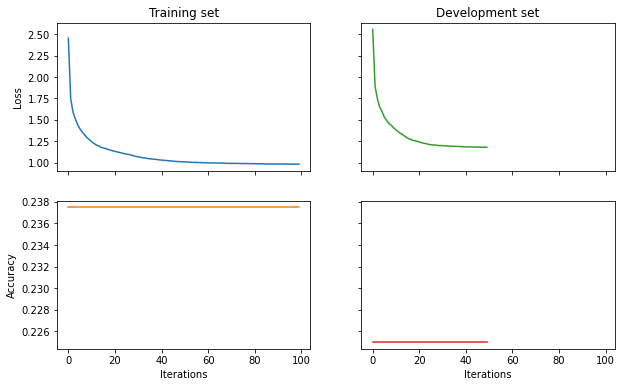

In [56]:
# Below some basic insights on the training and fitting process. 
# Next up: think of relevant and new images

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print val accuracy
val_acc = acc(model_CM(val_circuit_tot), val_labels)
print('Validation accuracy:', val_acc.item())